# NFT Data Processing Script
This notebook processes Ethereum NFT data by computing various metrics on token transactions, filtering flagged NFTs, and saving the processed data in separate files for each collection.

### Load Data Function

The **`load_data`** function reads two datasets based on the file name provided.
   - **NFT Ownership Traces**: Contains transaction history for NFTs.
   - **Flagged NFTs**: Contains information on NFTs flagged for potential wash trading.
 
1. **Handles Missing Data** It fills any NaN values in the price_usd and price_eth columns with 0.
2. **Return** the data as two separate pandas DataFrames for further manipulation and analysis.

**Parameters**:
- `file_name`: The name of the dataset file (CSV) to be loaded from the directories.

**Output**:
- Two DataFrames:
   - **`nft_ownership_traces_df`**: DataFrame of NFT ownership trace data.
   - **`flagged_nfts_df`**: DataFrame of flagged NFT data.

In [1]:
def load_data(file_name):
    """
    Load the NFT ownership traces and flagged NFTs data for a given file name.
    Fill NaN values in price columns with 0.
    """
    # Load the data
    nft_ownership_traces_df = pd.read_csv(os.path.join(nft_ownership_traces_dir, file_name))
    flagged_nfts_df = pd.read_csv(os.path.join(flagged_nfts_dir, file_name))
    
    # Fill NaN values in price columns with 0
    nft_ownership_traces_df['price_usd'] = nft_ownership_traces_df['price_usd'].fillna(0)
    nft_ownership_traces_df['price_eth'] = nft_ownership_traces_df['price_eth'].fillna(0)

    return nft_ownership_traces_df, flagged_nfts_df

### Compute Token Metrics

The **`compute_token_metrics`** function calculates metrics for each NFT token. 
These metrics will be further used as feature set for the model training.

#### Metrics calculated:
   
1. **Holding Time**: Average duration a token is held between transactions.
2. **Token Lifespan**: Total time from the first to last transaction for each token.
3. **Price Statistics** (USD and ETH): Includes average, median, min, max, standard deviation, and total volume.
4. **Transaction Timing**: Average, min, and max intervals between transactions.
5. **Price Change**: Average, min, and max price changes per token.
6. **Price Trend**: Indicates if the token’s price trend is increasing, decreasing, or mixed.
7. **Cycles Count**: Number of unique wallet pairs involved in token transactions.

#### Parameters:
- `nft_ownership_traces_df`: DataFrame containing the ownership trace data for NFTs.

#### Returns:
- `metrics_df`: DataFrame with all calculated metrics for each token.

In [2]:
import numpy as np
import pandas as pd

def calculate_price_trend(nft_ownership_traces_df):
    # Calculate price change in USD
    nft_ownership_traces_df['price_change_usd'] = nft_ownership_traces_df.groupby('token_id')['price_usd'].diff()
    
    # Calculate average price change for each token
    avg_price_change_usd = nft_ownership_traces_df.groupby('token_id')['price_change_usd'].mean()
    
    # Determine the price trend
    trend_numeric = []
    for token_id in avg_price_change_usd.index:
        avg_change = avg_price_change_usd[token_id]
        if avg_change > 0:
            trend_numeric.append((token_id, 1))  # Increasing
        elif avg_change < 0:
            trend_numeric.append((token_id, -1))  # Decreasing
        else:
            trend_numeric.append((token_id, 0))  # Mixed 

    trend_df = pd.DataFrame(trend_numeric, columns=['token_id', 'price_trend'])
    trend_df.set_index('token_id', inplace=True)

    return trend_df

def calculate_cycles(nft_ownership_traces_df):
    cycles_count = {}
    
    # Group by token_id
    grouped = nft_ownership_traces_df.groupby('token_id')
    
    for token_id, group in grouped:
        # Create a list of unique wallets involved in transactions for the token
        unique_wallets = set(group['from']).union(set(group['to']))
        
        # Count cycles
        wallet_pairs = set()
        # Find the number of unique wallet pairs
        for i in range(len(group)):
            from_wallet = group.iloc[i]['from']
            to_wallet = group.iloc[i]['to']
            if from_wallet != to_wallet:
                pair = tuple(sorted([from_wallet, to_wallet]))
                wallet_pairs.add(pair)
        
        cycles_count[token_id] = len(wallet_pairs)
    
    cycles_df = pd.DataFrame(list(cycles_count.items()), columns=['token_id', 'cycles_count'])
    cycles_df.set_index('token_id', inplace=True)

    return cycles_df


def compute_token_metrics(nft_ownership_traces_df):

    # Convert timestamp to datetime format for further manipulation
    nft_ownership_traces_df['timestamp'] = pd.to_datetime(nft_ownership_traces_df['timestamp'], unit='s')
    
    # Calculate average holding time
    nft_ownership_traces_df = nft_ownership_traces_df.sort_values(by=['token_id', 'timestamp'])
    nft_ownership_traces_df['holding_time'] = nft_ownership_traces_df.groupby('token_id')['timestamp'].diff().dt.total_seconds()
    avg_holding_time_seconds = nft_ownership_traces_df.groupby('token_id')['holding_time'].mean()
    
    # Calculate lifespan of each token
    lifespan_seconds = nft_ownership_traces_df.groupby('token_id')['timestamp'].agg(lambda x: (x.max() - x.min()).total_seconds())
    
    # Calculate price metrics
    avg_price_usd = nft_ownership_traces_df.groupby('token_id')['price_usd'].mean()
    med_price_usd = nft_ownership_traces_df.groupby('token_id')['price_usd'].median()
    min_price_usd = nft_ownership_traces_df.groupby('token_id')['price_usd'].min()
    max_price_usd = nft_ownership_traces_df.groupby('token_id')['price_usd'].max()
    std_price_usd = nft_ownership_traces_df.groupby('token_id')['price_usd'].std()
    total_volume_usd = nft_ownership_traces_df.groupby('token_id')['price_usd'].sum()
    
    avg_price_eth = nft_ownership_traces_df.groupby('token_id')['price_eth'].mean()
    med_price_eth = nft_ownership_traces_df.groupby('token_id')['price_eth'].median()
    min_price_eth = nft_ownership_traces_df.groupby('token_id')['price_eth'].min()
    max_price_eth = nft_ownership_traces_df.groupby('token_id')['price_eth'].max()
    std_price_eth = nft_ownership_traces_df.groupby('token_id')['price_eth'].std()
    total_volume_eth = nft_ownership_traces_df.groupby('token_id')['price_eth'].sum()
    
    # Calculate time-related metrics
    nft_ownership_traces_df['time_between_transactions'] = nft_ownership_traces_df.groupby('token_id')['timestamp'].diff().dt.total_seconds()
    avg_time_between_transactions = nft_ownership_traces_df.groupby('token_id')['time_between_transactions'].mean()
    min_time_between_transactions = nft_ownership_traces_df.groupby('token_id')['time_between_transactions'].min()
    max_time_between_transactions = nft_ownership_traces_df.groupby('token_id')['time_between_transactions'].max()
    
    # Calculate price change metrics
    nft_ownership_traces_df['price_change_usd'] = nft_ownership_traces_df.groupby('token_id')['price_usd'].diff()
    nft_ownership_traces_df['price_change_eth'] = nft_ownership_traces_df.groupby('token_id')['price_eth'].diff()
    
    avg_price_change_usd = nft_ownership_traces_df.groupby('token_id')['price_change_usd'].mean()
    min_price_change_usd = nft_ownership_traces_df.groupby('token_id')['price_change_usd'].min()
    max_price_change_usd = nft_ownership_traces_df.groupby('token_id')['price_change_usd'].max()

    avg_price_change_eth = nft_ownership_traces_df.groupby('token_id')['price_change_eth'].mean()
    min_price_change_eth = nft_ownership_traces_df.groupby('token_id')['price_change_eth'].min()
    max_price_change_eth = nft_ownership_traces_df.groupby('token_id')['price_change_eth'].max()

    # Calculate price trend metric
    price_trend_df = calculate_price_trend(nft_ownership_traces_df)

    # Calculate cycles metric
    cycles_df = calculate_cycles(nft_ownership_traces_df)
    
    # Merge metrics into a single DataFrame
    metrics_df = avg_price_usd.to_frame(name='avg_price_usd').join(
        med_price_usd.rename('med_price_usd')).join(
        min_price_usd.rename('min_price_usd')).join(
        max_price_usd.rename('max_price_usd')).join(
        std_price_usd.rename('price_volatility_usd')).join(
        total_volume_usd.rename('total_volume_usd')).join(
        avg_price_eth.rename('avg_price_eth')).join(
        med_price_eth.rename('med_price_eth')).join(
        min_price_eth.rename('min_price_eth')).join(
        max_price_eth.rename('max_price_eth')).join(
        std_price_eth.rename('price_volatility_eth')).join(
        total_volume_eth.rename('total_volume_eth')).join(
        avg_holding_time_seconds.rename('avg_holding_time_seconds')).join(
        lifespan_seconds.rename('lifespan_seconds')).join(
        avg_time_between_transactions.rename('avg_time_between_transactions')).join(
        min_time_between_transactions.rename('min_time_between_transactions')).join(
        max_time_between_transactions.rename('max_time_between_transactions')).join(
        avg_price_change_usd.rename('avg_price_change_usd')).join(
        min_price_change_usd.rename('min_price_change_usd')).join(
        max_price_change_usd.rename('max_price_change_usd')).join(
        avg_price_change_eth.rename('avg_price_change_eth')).join(
        min_price_change_eth.rename('min_price_change_eth')).join(
        max_price_change_eth.rename('max_price_change_eth')).join(
        price_trend_df).join(
        cycles_df)
    
    return metrics_df

### Filter Flagged NFTs

The **`filter_flagged_nfts`** function selects only flagged NFTs that have been involved in more than one transaction.

#### Parameters:
- `flagged_nfts_df`: DataFrame of flagged NFTs.
- `token_count`: Series with the transaction count for each token.

#### Returns:
- Filtered DataFrame of flagged NFTs with tokens having multiple transactions.


In [3]:
def filter_flagged_nfts(flagged_nfts_df, token_count):
    """
    Filter flagged NFTs to include only tokens involved in more than one transaction.
    """
    return flagged_nfts_df[flagged_nfts_df['token_id'].isin(token_count[token_count > 1].index)].copy()


### Main Processing Workflow

This workflow processes each **flagged NFT CSV file**:
1. Loads the **NFT ownership traces** and **flagged NFTs** for each file.
2. Computes transaction counts per token.
3. Retains only tokens with more than one transaction.
4. Generates metrics for each token.
5. Merges filtered flagged NFTs with computed metrics and saves the results to the working directory.

#### Directories:
- **NFT Ownership Traces** and **Flagged NFTs**: Source data directories.
- **Working Directory**: Destination for processed output files.

At the end, each processed file is saved as a CSV in the working directory.


In [4]:
import numpy as np
import pandas as pd 

import os

# Paths to the input directories and the working directory.
nft_ownership_traces_dir = '/kaggle/input/ethereum-nfts-flagged-for-suspected-wash-trading/nft_ownership_traces'
flagged_nfts_dir = '/kaggle/input/ethereum-nfts-flagged-for-suspected-wash-trading/flagged_nfts'
working_dir = '/kaggle/working/'

# List all CSV files in the flagged NFTs directory.
csv_files_flagged = [file for file in os.listdir(flagged_nfts_dir) if file.endswith('.csv')]

# Main Processing Loop
for file_name in csv_files_flagged:
    # Load data
    nft_ownership_traces_df, flagged_nfts_df = load_data(file_name)
    
    # Compute token transaction counts
    token_count = nft_ownership_traces_df['token_id'].value_counts()
    
    # Filter flagged NFTs based on transaction count
    filtered_flagged_nfts_df = filter_flagged_nfts(flagged_nfts_df, token_count)
    
    # Calculate metrics
    metrics_df = compute_token_metrics(nft_ownership_traces_df)
    # Merge metrics and flagged NFTs DataFrame
    merged_df = filtered_flagged_nfts_df.merge(metrics_df, on='token_id', how='left')
    
    merged_df.to_csv(os.path.join(working_dir, f'{file_name}'), index=False)

print("Processing complete. Merged files have been saved.")

Processing complete. Merged files have been saved.


### `analyze_flagged_trades` Function
To check if the filtering improves balance in `flagged_trades`

#### Parameters:
- **`flagged_nfts_dir`** (str): Directory containing the original flagged NFT data.
- **`working_dir`** (str): Directory containing the filtered NFT data.

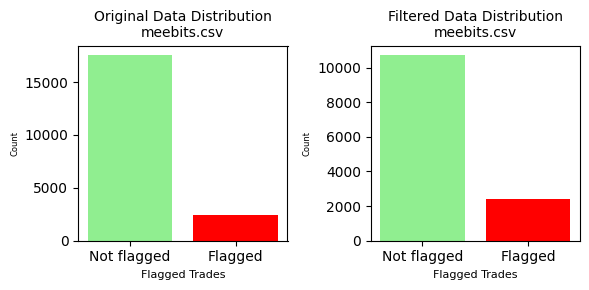

File: meebits.csv
Number of 0 values in 'flagged_trades' before filtering: 17573
Number of 0 values in 'flagged_trades' after filtering: 10732
Number of non-zero values in 'flagged_trades': 2427
--------------------------------------------------


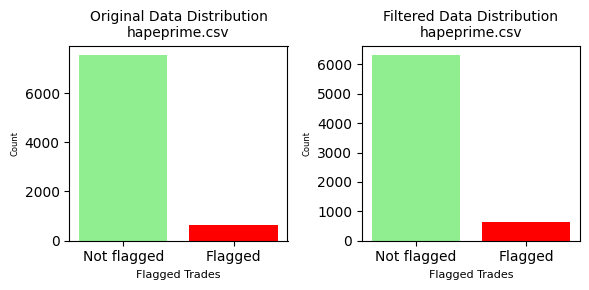

File: hapeprime.csv
Number of 0 values in 'flagged_trades' before filtering: 7552
Number of 0 values in 'flagged_trades' after filtering: 6326
Number of non-zero values in 'flagged_trades': 640
--------------------------------------------------


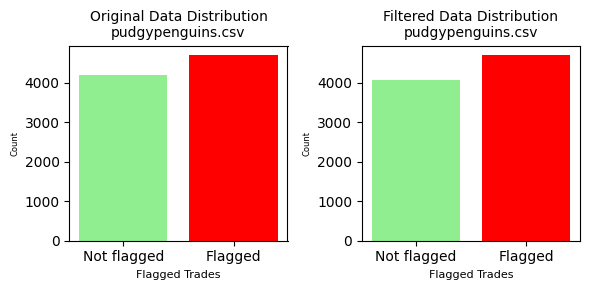

File: pudgypenguins.csv
Number of 0 values in 'flagged_trades' before filtering: 4187
Number of 0 values in 'flagged_trades' after filtering: 4066
Number of non-zero values in 'flagged_trades': 4701
--------------------------------------------------


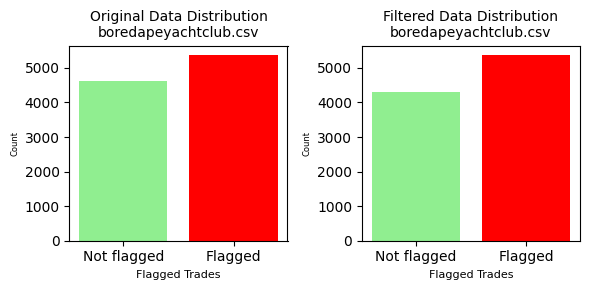

File: boredapeyachtclub.csv
Number of 0 values in 'flagged_trades' before filtering: 4623
Number of 0 values in 'flagged_trades' after filtering: 4314
Number of non-zero values in 'flagged_trades': 5377
--------------------------------------------------


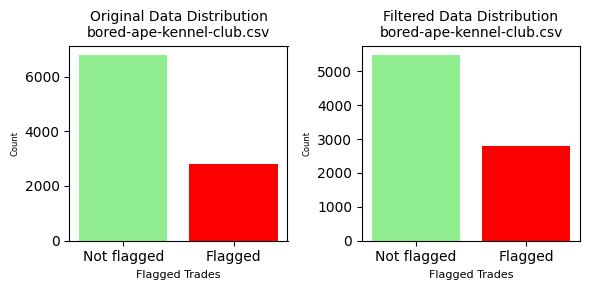

File: bored-ape-kennel-club.csv
Number of 0 values in 'flagged_trades' before filtering: 6794
Number of 0 values in 'flagged_trades' after filtering: 5487
Number of non-zero values in 'flagged_trades': 2808
--------------------------------------------------


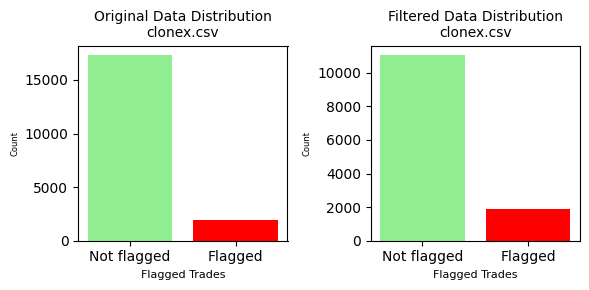

File: clonex.csv
Number of 0 values in 'flagged_trades' before filtering: 17344
Number of 0 values in 'flagged_trades' after filtering: 11068
Number of non-zero values in 'flagged_trades': 1902
--------------------------------------------------


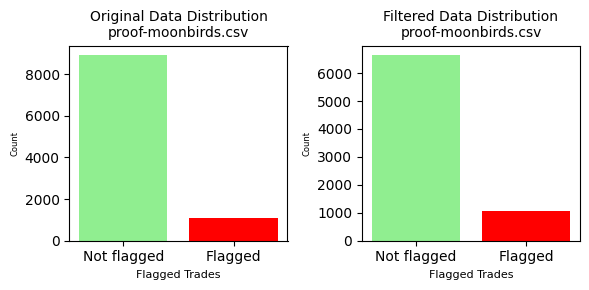

File: proof-moonbirds.csv
Number of 0 values in 'flagged_trades' before filtering: 8924
Number of 0 values in 'flagged_trades' after filtering: 6654
Number of non-zero values in 'flagged_trades': 1076
--------------------------------------------------


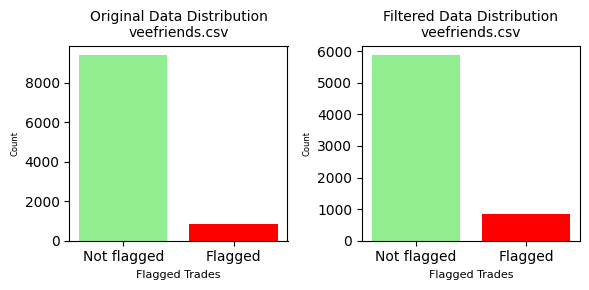

File: veefriends.csv
Number of 0 values in 'flagged_trades' before filtering: 9413
Number of 0 values in 'flagged_trades' after filtering: 5884
Number of non-zero values in 'flagged_trades': 842
--------------------------------------------------


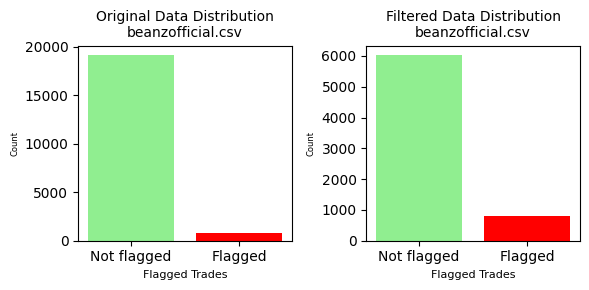

File: beanzofficial.csv
Number of 0 values in 'flagged_trades' before filtering: 19155
Number of 0 values in 'flagged_trades' after filtering: 6036
Number of non-zero values in 'flagged_trades': 795
--------------------------------------------------


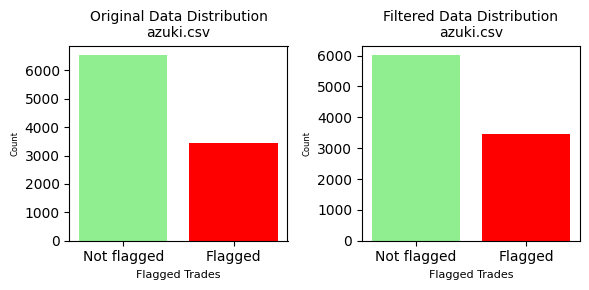

File: azuki.csv
Number of 0 values in 'flagged_trades' before filtering: 6546
Number of 0 values in 'flagged_trades' after filtering: 6026
Number of non-zero values in 'flagged_trades': 3454
--------------------------------------------------


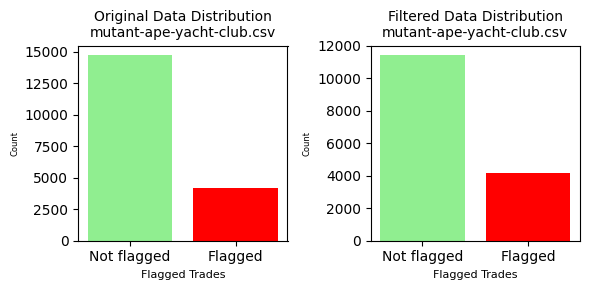

File: mutant-ape-yacht-club.csv
Number of 0 values in 'flagged_trades' before filtering: 14768
Number of 0 values in 'flagged_trades' after filtering: 11454
Number of non-zero values in 'flagged_trades': 4197
--------------------------------------------------


In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def analyze_flagged_trades(flagged_nfts_dir, working_dir):
    # List of CSV files in the flagged NFTs directory
    csv_files_flagged = [file for file in os.listdir(flagged_nfts_dir) if file.endswith('.csv')]

    # Process each file
    for file_name in csv_files_flagged:
        # Load the original and filtered data
        data = pd.read_csv(os.path.join(flagged_nfts_dir, file_name))
        filtered_data = pd.read_csv(os.path.join(working_dir, file_name))

        # Count occurrences of 0 and non-zero 'flagged_trades' values before and after filtering
        zero_count = (data['flagged_trades'] == 0).sum()
        non_zero_count = (data['flagged_trades'] != 0).sum()
        zero_count_filtered = (filtered_data['flagged_trades'] == 0).sum()
        non_zero_count_filtered = (filtered_data['flagged_trades'] != 0).sum()

        # Bar Chart visualization
        fig, ax = plt.subplots(1, 2, figsize=(6, 3))
        counts_before = [zero_count, non_zero_count]
        counts_after = [zero_count_filtered, non_zero_count_filtered]

        # Bar chart for original data
        ax[0].bar(['Not flagged', 'Flagged'], counts_before, color=['lightgreen', 'red'])
        ax[0].set_title(f'Original Data Distribution\n{file_name}', fontsize=10)
        ax[0].set_xlabel('Flagged Trades', fontsize=8)
        ax[0].set_ylabel('Count', fontsize=6)

        # Bar chart for filtered data
        ax[1].bar(['Not flagged', 'Flagged'], counts_after, color=['lightgreen', 'red'])
        ax[1].set_title(f'Filtered Data Distribution\n{file_name}', fontsize=10)
        ax[1].set_xlabel('Flagged Trades', fontsize=8)
        ax[1].set_ylabel('Count', fontsize=6)

        # Display the plots
        plt.tight_layout()
        plt.show()

        # Print results
        print(f"File: {file_name}")
        print(f"Number of 0 values in 'flagged_trades' before filtering: {zero_count}")
        print(f"Number of 0 values in 'flagged_trades' after filtering: {zero_count_filtered}")
        print(f"Number of non-zero values in 'flagged_trades': {non_zero_count_filtered}")
        print("-" * 50)

flagged_nfts_dir = '/kaggle/input/ethereum-nfts-flagged-for-suspected-wash-trading/flagged_nfts'
working_dir = '/kaggle/working/'
analyze_flagged_trades(flagged_nfts_dir, working_dir)


### `display_csv_headings` Function
List all CSV files in the working directory and display their names and the first 5 rows.

#### Parameters:
- **`working_dir`** (str): The directory containing the CSV files.

In [6]:
import os
import pandas as pd

def display_csv_headings(working_dir):
    # List all CSV files in the working directory
    csv_files_working = [file for file in os.listdir(working_dir) if file.endswith('.csv')]

    # Visualize the newly added metrics
    for file_name in csv_files_working:
        file_path = os.path.join(working_dir, file_name)
        data = pd.read_csv(file_path)
        
        # Display the file name and the first 5 rows (head)
        print(f"File: {file_name}")
        print(data.head(), "\n")

display_csv_headings('/kaggle/working/')


File: azuki.csv
   token_id  flagged_trades  avg_price_usd  med_price_usd  min_price_usd  \
0         3               0            0.0            0.0            0.0   
1         5               0            0.0            0.0            0.0   
2        19               0            0.0            0.0            0.0   
3        36               0            0.0            0.0            0.0   
4        40               0            0.0            0.0            0.0   

   max_price_usd  price_volatility_usd  total_volume_usd  avg_price_eth  \
0            0.0                   0.0               0.0            0.0   
1            0.0                   0.0               0.0            0.0   
2            0.0                   0.0               0.0            0.0   
3            0.0                   0.0               0.0            0.0   
4            0.0                   0.0               0.0            0.0   

   med_price_eth  ...  min_time_between_transactions  \
0            0.0  ..